# Learning from Imbalanced Data - Part C

## Tutorial support notebook


This notebook supports the slides of the tutorial on "Learning from Imbalanced Data" that was presented in the 14th International Conference on Information, Intelligence, Systems and Applications (IISA 2023), University of Thessaly, Volos, Greece.

This part demonstrates how to create synthetic data for the inority classes using deep generativel models:
* Variational Autoencoders (VAEs)
* Generative Adversarial Networks (GANs)


**Author: Leonidas Akritidis**

**Last update: 10/07/2023**


In [1]:
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.autograd import Variable

from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Used for creating training and test sets
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Classification models
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation Measures
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, classification_report

import random

seed=42
num_samples=1000
imbalance_ratio = [0.95,0.05]
num_classes=len(imbalance_ratio)
oversampling_ratio=1.0

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

## Creating an imbalanced dataset

The experiments will be based on a synthetic dataset generated with scikit-learn's `make_classification` function. We will build a test dataset with `num_samples` two-dimensional examples and `len(imbalance_ratio)` classes. The `imbalance_ratio` determines the imbalance between the majority and the minorty class/es.


<AxesSubplot:>

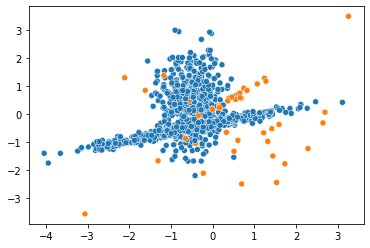

In [2]:
dataset = make_classification(n_samples=num_samples, n_features=2, n_clusters_per_class=2,
                              n_classes=num_classes, weights=imbalance_ratio, flip_y=0, class_sep=0.5,
                              n_informative=2, n_redundant=0, n_repeated=0, random_state=seed)

X = dataset[0]
y = dataset[1]

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, legend=False)


Print the distribution of samples in the dataset classes:

In [3]:
print("Class Distribution:")

for k in range(num_classes):
    print("Class", k, ":", len(y[y==k]), "samples")


Class Distribution:
Class 0 : 950 samples
Class 1 : 50 samples


We prepare the dataset for classification. We split it into a training and a test set in a ratio $4:1$; in other words, 80% of the original data will be used for training, and 20% will be used for testing. Stratifying by the target variable guarantees that the distributions of the dataset classes will be (about) the same in the training and test sets.


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)


Print and plot the distribution of samples in the classes of the test set:

Class 0 : 190 samples
Class 1 : 10 samples


Text(0.5, 1.0, 'Class distribution in the test set\n')

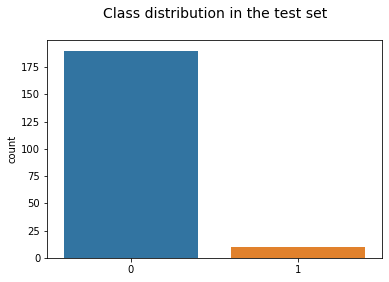

In [5]:
for k in range(num_classes):
    print("Class", k, ":", len(y_test[y_test==k]), "samples")

sns.countplot(x=y_test)
plt.title('Class distribution in the test set\n', fontsize=14)


## Classification

We will use five simple machine learning models to perform classification:
 * **Logistic Regression**
 * **Decision Tree classifier** without restriction in the depth and the features.
 * **Random Forest classifier** with 100 Decision Trees. The estimators have the same attributes, i.e. no depth/feature restriction.
 * **Support Vector Machines (SVM)** with the Radial Basis Function as a kernel
 * **Multilayer Perceptron (FCFF: Fully-Connected Feed-Forward Network)** with 2 hidden layers and the `ReLU` activation function.


In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=300, random_state=seed),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features=None, random_state=seed),
    "Random Forest": RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, max_features='sqrt',
                                       n_jobs=8, random_state=seed),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1, random_state=seed),
    "FCFF Neural Net": MLPClassifier(activation='relu', hidden_layer_sizes=(16, 4), solver='adam', random_state=seed),
}

Results_over = []


`plot_decision_regions_2D()`: The following function plots the dataset and the decision boundaries that are determined by each classifier.


In [7]:
def plot_decision_regions_2D(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 'o', 'o', 'o', 's', 'v', '^')
    colors = ('#1f77b4', '#ff7f0e', 'red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    x2_min, x2_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    
    # meshgrid: Return coordinate matrices from coordinate vectors. More specifically, we make N-D coordinate arrays
    # for vectorized evaluations of N-D scalar/vector fields over N-D grids, given one-dimensional coordinate arrays.
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

    # ravel: Return a contiguous flattened array.
    # T: the transpose matrix
    X_test_in = np.array([xx1.ravel(), xx2.ravel()]).T
    # print(X_test)

    Z = classifier.predict(X_test_in)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.15, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0], y=X[y==cl,1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl, edgecolor='white')


`TrainTestModel()`: A parametric function that trains and tests a classifier.


In [8]:
def TrainTestModel(train_X, test_X, train_y, test_y, mdl, res, desc):

        t0 = time.time()
        print("Training", mdl + "...\t", end="", flush=True)

        clf = models[mdl]
        clf.fit(train_X, train_y)

        print("  (%5.3f sec). \t" % (time.time() - t0), end="", flush=True)

        y_predicted = clf.predict(test_X)

        acc = accuracy_score(test_y, y_predicted)
        bacc = balanced_accuracy_score(test_y, y_predicted)

        if num_classes == 2:
            fpr, tpr, thresholds = roc_curve(test_y, y_predicted)
            auc_m = auc(fpr, tpr)
        else:
            auc_m = bacc

        print("Accuracy=%5.4f" % acc, "\tBalanced Accuracy=%5.4f"% bacc, "\tAUC=%5.4f" % auc_m, flush=True)

        res.append([mdl, desc, acc, bacc, auc_m])

        X_stacked = np.vstack((train_X, test_X))
        Y_stacked = np.hstack((train_y, test_y))

        plot_decision_regions_2D(X_stacked, Y_stacked, clf)
        plt.xlabel("x0")
        plt.ylabel("x1")
        plt.title(mdl + " (Accuracy: " + (str)(round(acc, 3)) + ", AUC: " + (str)(round(auc_m, 3)) + ")")
        plt.legend(loc='upper left')


## Training and testing the classifiers on the original dataset


Training Logistic Regression...	  (0.011 sec). 	Accuracy=0.9500 	Balanced Accuracy=0.5000 	AUC=0.5000
Training Decision Tree...	  (0.003 sec). 	Accuracy=0.9600 	Balanced Accuracy=0.6947 	AUC=0.6947
Training Random Forest...	  (0.073 sec). 	Accuracy=0.9650 	Balanced Accuracy=0.6500 	AUC=0.6500
Training SVM (RBF Kernel)...	  (0.004 sec). 	Accuracy=0.9600 	Balanced Accuracy=0.6000 	AUC=0.6000
Training FCFF Neural Net...	  (0.313 sec). 	Accuracy=0.9550 	Balanced Accuracy=0.5500 	AUC=0.5500


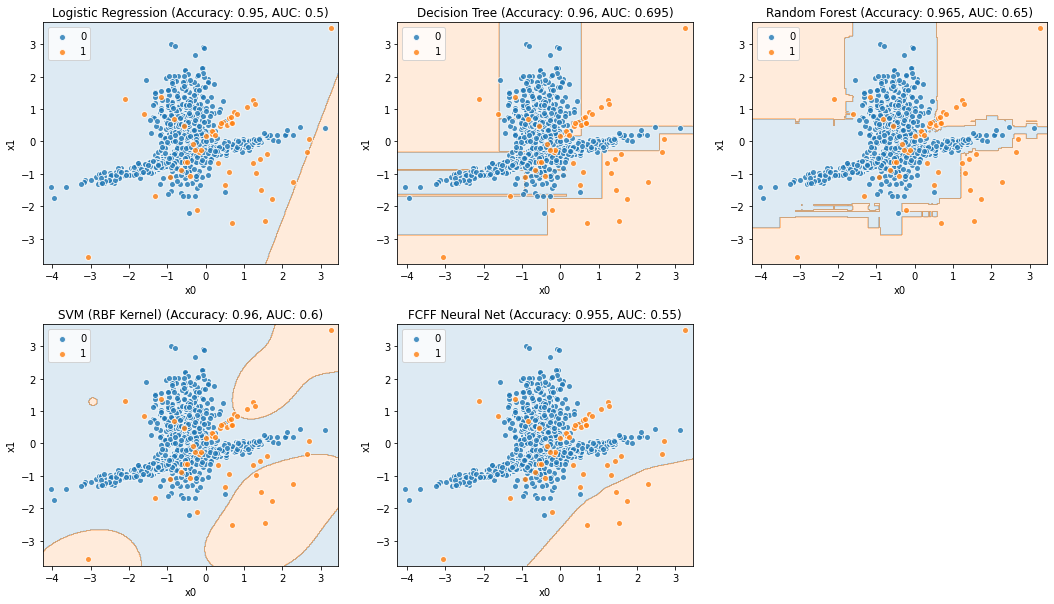

In [9]:
fig = plt.figure(figsize=(18, 10))

itr = 0

for model in models:
    itr = itr + 1
    plt.subplot(2, 3, itr)
    TrainTestModel(X_train, X_test, y_train, y_test, model, Results_over, "Original data")

plt.subplots_adjust(hspace=0.25)

Results_under = Results_over.copy()


## Tackling class imbalance with Deep Generative Models

Generative modeling is an unsupervised learning task that automatically discovers patterns in the input data. In this way the model can generate new examples that are similar to the ones that exist in the original dataset.

Examples of deep Generative Models include:
* Variational Autoencoders (VAEs).
* Generative Adversarial Networks (GANs).
* Deep Belief Networks (DBNs).
* Generative Transformers.

In this notebook we will study how we can oversample the minority class with VAEs and GANs. At first we begin by splitting the training set into two sets:
* `train_minority_samples` contains the samples of the minority class, and
* `train_majority_samples` contains the samples of the minority class.

The first one will be augmented by synthetic samples


In [10]:
# Split the training set into minority and majority samples
train_minority_samples = np.array([ X_train[k] for k in range(X_train.shape[0]) if y_train[k] == 1 ])

train_majority_samples = np.array([ X_train[k] for k in range(X_train.shape[0]) if y_train[k] == 0 ])

# The minority samples will be used to train the Generative models
x_train_tensor = torch.from_numpy(train_minority_samples).to(torch.float32)

# Create batches of training data
trainloader = DataLoader(dataset=x_train_tensor, batch_size=1024)


### Oversampling with Variational Autoencoders (VAE)

The Autoencoder (AE) is topologically identical to a standard, fully-connected feed-forward neural network. It is an unsupervised learning model, trained to reproduce its input $\mathbf{x}$ as accurately as possible.

If $\mathbf{\hat{x}}$ is the output of the network, then the Autoencoder attempts to minimize the reconstruction error $\mathcal{L}(\mathbf{x}, \mathbf{\hat{x}})$ that quantifies the distance between $\mathbf{x}$ and $\mathbf{\hat{x}}$.

The encoder part compresses the data from the initial space to the latent space. The decoder part decompresses it. However, the latent space $\mathbf{z}$ produced by the encoder is sparse and it is very difficult to predict the distribution of values in that space. Finding a latent value for which the decoder will produce meaningful data is almost impossible.
If the space has gaps between clusters and the decoder receives a variation from there, it will lack the knowledge to generate something useful.

<div>
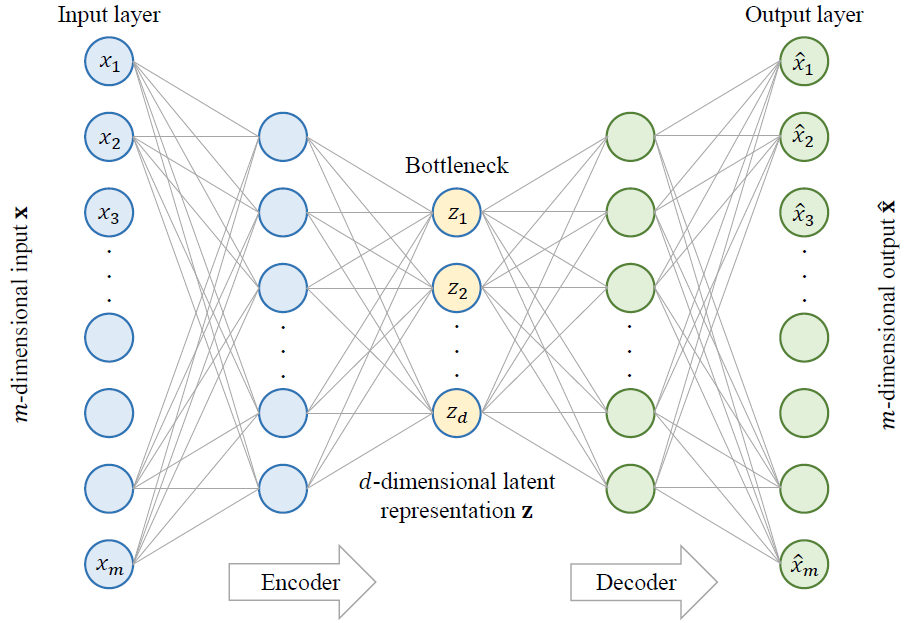
</div>


VAE is an Autoencoder whose encodings distribution is regularized during training to ensure that its latent space has good properties. These properties allow us to generate meaningful data. The term "variational" comes from the variational inference statistical method that allows the estimation of a probability distribution.

**VAEs encode an input sample as a probability distribution over the latent space (instead of encoding it as a single point like AEs).**




<div>
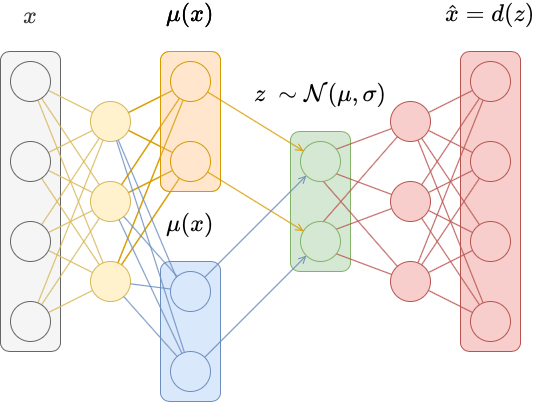
</div>


In [11]:
class VAE(nn.Module):
    def __init__(self, dimensionality=2, latent_dimensionality=3, architecture=[12, 6]):
        super(VAE, self).__init__()
        
        H2 = architecture[1]
        H = architecture[0]

        # Encoder
        self.linear1 = nn.Linear(dimensionality, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dimensionality)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dimensionality)
        self.fc21 = nn.Linear(latent_dimensionality, latent_dimensionality)
        self.fc22 = nn.Linear(latent_dimensionality, latent_dimensionality)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dimensionality, latent_dimensionality)
        self.fc_bn3 = nn.BatchNorm1d(latent_dimensionality)
        self.fc4 = nn.Linear(latent_dimensionality, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
        # Decoder
        self.linear4=nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,dimensionality)
        self.lin_bn6 = nn.BatchNorm1d(num_features=dimensionality)
        
        self.relu = nn.ReLU()

    # Encode method
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

    # Reparametrization trick
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    # Decode method
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In the following code block we create an instance of the `VAE` class and we train the model.


In [12]:
# Our VAE model
model = VAE(dimensionality=trainloader.dataset.shape[1], latent_dimensionality=3, architecture=[9, 6]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the custom loss
vae_loss = customLoss()

epochs = 1500
log_interval = 50
val_losses = []
train_losses = []
test_losses = []

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

for epoch in range(1, epochs + 1):
    train(epoch)

====> Epoch: 200 Average training loss: 4.6524
====> Epoch: 400 Average training loss: 3.4966
====> Epoch: 600 Average training loss: 3.1598
====> Epoch: 800 Average training loss: 3.3681
====> Epoch: 1000 Average training loss: 3.1763
====> Epoch: 1200 Average training loss: 2.6631
====> Epoch: 1400 Average training loss: 2.8983


At this point we have the VAE model trained. Now let us use learned probability distribution to generate synthetic samples.  The objective is to provide vectors with `latent_dimensionality` components and let the VAE decode them to obtain the synhtetic samples.

* `Mu` represents the mean for each latent factor values
* `logvar` is the log of the standard deviation.

Each `Mu` and `logvar` describe an individual Gaussian distribution.

All of the latent variables have a mean around zero, but the last latent factor has a wider standard deviation. So when we sample values from each of these latent variables, the last value will vary much more then the other two. I assume a normal distribution for all the latent factors.


In [13]:
# Feed the training set to the VAE and get the mean value & log of standard deviation of the learned distribution
with torch.no_grad():
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

# Standard deviation of the learned distribution
sigma = torch.exp(logvar/2)

# How many samples to generate? (The difference between the majority and minority samples)
no_samples = len(train_majority_samples) - len(train_minority_samples)

# Set up a Gaussian distribution with the mean and standard deviations returned by the VAE
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))

# Take random samples from the Gaussian
z = q.rsample(sample_shape=torch.Size([no_samples]))

# Reconstruct the Gaussian samples by feeding them to the VAE's Decoder
with torch.no_grad():
    synthetic_samples = model.decode(z).cpu().numpy()


(-4.0, 4.0)

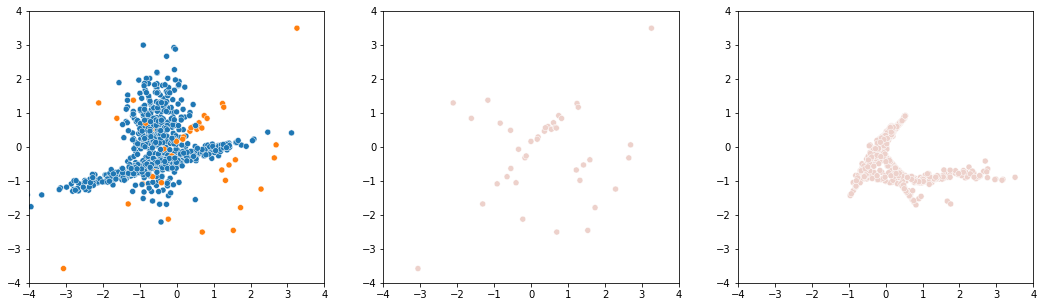

In [14]:
fig = plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train, legend=False)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

plt.subplot(1, 3, 2)
sns.scatterplot(x=train_minority_samples[:,0], y=train_minority_samples[:,1], hue=5, legend=False)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

plt.subplot(1, 3, 3)
sns.scatterplot(x=synthetic_samples[:,0], y=synthetic_samples[:,1], hue=5, legend=False)
plt.xlim(-4, 4)
plt.ylim(-4, 4)


In [15]:
print("Xtrain original:", X_train.shape)
print("synthetic_samples:", synthetic_samples.shape)
print("train_minority_samples:", train_minority_samples.shape)
print("train_majority_samples", train_majority_samples.shape)

X_over_train = np.vstack((X_train, synthetic_samples))
print("Xtrain after:", X_train.shape)

min_classes = np.ones(no_samples)

y_over_train = np.hstack((y_train, min_classes))


Xtrain original: (800, 2)
synthetic_samples: (720, 2)
train_minority_samples: (40, 2)
train_majority_samples (760, 2)
Xtrain after: (800, 2)


Training Logistic Regression...	  (0.005 sec). 	Accuracy=0.7950 	Balanced Accuracy=0.7974 	AUC=0.7974
Training Decision Tree...	  (0.000 sec). 	Accuracy=0.9150 	Balanced Accuracy=0.9553 	AUC=0.9553
Training Random Forest...	  (0.124 sec). 	Accuracy=0.9200 	Balanced Accuracy=0.9105 	AUC=0.9105
Training SVM (RBF Kernel)...	  (0.048 sec). 	Accuracy=0.8950 	Balanced Accuracy=0.8500 	AUC=0.8500
Training FCFF Neural Net...	  (0.602 sec). 	Accuracy=0.9350 	Balanced Accuracy=0.9184 	AUC=0.9184


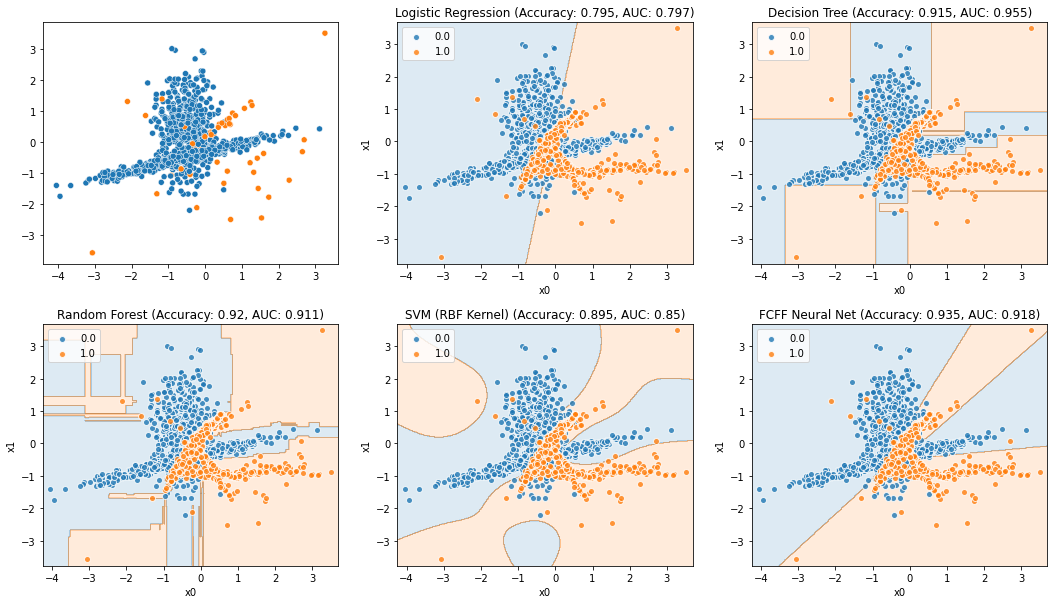

In [16]:
fig = plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, legend=False)

itr = 1
for model in models:
    itr = itr + 1
    plt.subplot(2, 3, itr)
    TrainTestModel(X_over_train, X_test, y_over_train, y_test, model, Results_over, "VAE")

plt.subplots_adjust(hspace=0.25)


### Oversampling with Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) are an approach to generative modeling using deep learning methods, such as Convolutional Neural Networks. Inside a GAN, two Neural Networks compete against each other to learn the target distribution and generate artificial data:

* A discriminator network $D$ receives the artificial training examples from $G$ and tries to understand whether they are fraud or not. Essentially, $D$ is a classifier that tries to correctly identify whether the input data is fake or real. The training process uses:
  * real data instances used as positive examples, and
  * fake data instances (coming from $G$), used as negative examples.

  The employed loss function must penalize the misclassifications (real data identified as fake, or fake data identified as real). At each iteration, $D$ updates its parameters using backpropagation, thus improving its ability to identify fake data instances.

* A generator network $G$ generates training samples with the aim of fooling the discriminator $D$. $G$ learns to create fake data by using the output of $D$. The goal of the generator is to cause the discriminator to classify its output as real. $G$ is trained simultaneously with $D$. The training involves the following phases:
  * Construct an initial random noise sample and use it to produce the output of $G$.
  * Feed the output of $G$ to the discriminator $D$.
  * Compute the discriminator loss.
  * Backpropagate using both $G$ and $D$ to compute the necessary gradients.
  * Use these gradients to update only the generator's weights.


In [19]:
# Data params
data_mean = 4
data_stddev = 1.25

# ### Uncomment only one of these to define what data is actually sent to the Discriminator
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)

print(data)
# print("Using data [%s]" % (name))


tensor([[ 0.3594,  0.4628],
        [ 0.6936, -2.5065],
        [ 0.1872,  0.2929],
        [ 2.2853, -1.2407],
        [-0.5576,  0.4886],
        [ 1.7305, -1.7871],
        [-0.1678, -0.3214],
        [-0.9207, -1.0872],
        [ 0.4565,  0.5999],
        [ 1.4177, -0.5317],
        [ 0.6053,  0.7112],
        [ 0.5475,  0.5198],
        [-0.2260, -2.1269],
        [ 1.2226, -0.6794],
        [-0.3421, -0.0690],
        [-3.0648, -3.5805],
        [ 1.3213, -0.9853],
        [ 2.6447, -0.3237],
        [ 0.3874,  0.5632],
        [-0.5492, -0.6347],
        [-2.1113,  1.2945],
        [ 0.6587,  0.5765],
        [-1.3123, -1.6795],
        [ 0.7467,  0.9212],
        [ 0.8241,  0.8385],
        [ 3.2575,  3.4946],
        [ 1.5336, -2.4574],
        [ 1.2423,  1.2777],
        [ 1.5909, -0.3795],
        [ 2.6929,  0.0601],
        [-0.6527, -0.8770],
        [-1.1719,  1.3749],
        [ 0.1647,  0.2266],
        [-0.1346, -0.2664],
        [-0.0052,  0.1615],
        [-0.4092, -1

In [17]:

# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)

def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 5000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1])))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1])))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1])))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))

    if matplotlib_is_available:
        print("Plotting the generated distribution...")
        values = extract(g_fake_data)
        print(" Values: %s" % (str(values)))
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)
        plt.show()


train()

Using data [Only 4 moments]
Epoch 0: D (0.9115065336227417 real_err, 0.5213323831558228 fake_err) G (0.896931529045105 err); Real Dist ([3.978435606539249, 1.2153518965671688]),  Fake Dist ([0.24268989458680154, 0.023116433635418043]) 
Epoch 100: D (0.6410635709762573 real_err, 0.6660724878311157 fake_err) G (0.7207956314086914 err); Real Dist ([3.937305054932833, 1.1942212643457975]),  Fake Dist ([0.754711099267006, 0.006778603887225588]) 
Epoch 200: D (0.47765353322029114 real_err, 0.44708943367004395 fake_err) G (0.9983213543891907 err); Real Dist ([3.9974888184070587, 1.1914953891254545]),  Fake Dist ([5.0994170999526975, 0.1411699100794665]) 
Epoch 300: D (0.4403038024902344 real_err, 0.39227303862571716 fake_err) G (0.8219931721687317 err); Real Dist ([3.921666056737304, 1.324705072245788]),  Fake Dist ([7.304557351112366, 1.11417933148508]) 
Epoch 400: D (0.6158908605575562 real_err, 0.5332847237586975 fake_err) G (0.8715061545372009 err); Real Dist ([4.006628386497497, 1.276234

Epoch 4000: D (0.6930949687957764 real_err, 0.6932274103164673 fake_err) G (0.6937585473060608 err); Real Dist ([4.019128530263901, 1.2377652046767251]),  Fake Dist ([4.100565715312958, 1.2628341230154103]) 
Epoch 4100: D (0.6931356191635132 real_err, 0.692679762840271 fake_err) G (0.6931483745574951 err); Real Dist ([3.985816901266575, 1.3112051224216212]),  Fake Dist ([3.9240429871082307, 1.278056776639704]) 
Epoch 4200: D (0.6970605254173279 real_err, 0.6919999718666077 fake_err) G (0.693705677986145 err); Real Dist ([3.928123075187206, 1.2014536403547469]),  Fake Dist ([3.980605193734169, 1.1931120465805773]) 
Epoch 4300: D (0.6927353739738464 real_err, 0.6946003437042236 fake_err) G (0.6917436718940735 err); Real Dist ([4.049615518867969, 1.2472742538121906]),  Fake Dist ([4.019944856643677, 1.2298419286692035]) 
Epoch 4400: D (0.69292151927948 real_err, 0.6940600275993347 fake_err) G (0.6936527490615845 err); Real Dist ([4.015943070620298, 1.281744729636403]),  Fake Dist ([3.9502

NameError: name 'matplotlib_is_available' is not defined